<a href="https://colab.research.google.com/github/Pablo1990/3D-deep-segmentation-protocol/blob/main/3D_deep_segmentation_protocol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3D deep segmentation protocol

Mount your google drive to access all your image files, segmentations, and custom models. This also ensures that any models you train are saved to your google drive. If you'd like to try out the notebook without your own files, please download the sample images from tissuenet (optional step in Setup below).

This notebook was inspired by Cellpose 2.0 notebook (https://github.com/MouseLand/cellpose) and the Zero-Cost Deep-Learning to Enhance Microscopy project (https://github.com/HenriquesLab/DeepLearning_Collab/wiki). Jointly developed by the Jacquemet (link to https://cellmig.org/) and Henriques (https://henriqueslab.github.io/) laboratories.

# 0. Installation setup

We will first install cellpose 2.0, check the GPU is working, and mount google drive to get your models and images.

## Installation

Install cellpose -- by default the torch GPU version is installed in COLAB notebook.

In [1]:
#!pip install "opencv-python-headless<4.3"
!pip install cellpose[gui] matplotlib plotly scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.2/215.2 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.6/284.6 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 MB 7.6 MB/s eta 0:00:00


(RECOMENDED) You can also connect google colab to your own computer in case you have a GPU by following: https://research.google.com/colaboratory/local-runtimes.html

Check CUDA version and that GPU is working in cellpose and import other libraries.

In [2]:
!nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Tue Nov 12 11:46:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8               9W /  7

## Mount google drive

Please mount your google drive and find your working folder with (if available) the model that you trained. If you want to train a model, create a folder in google drive with the images and the labels, either `_seg.npy` files from the cellpose gui, or `_masks.tif` files.

In [3]:

#@markdown ###Run this cell to connect your Google Drive to Colab

#@markdown * Click on the URL.

#@markdown * Sign in your Google Account.

#@markdown * Copy the authorization code.

#@markdown * Enter the authorization code.

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive".

#mounts user's Google Drive to Google Colab.

from google.colab import drive
drive.mount('/content/gdrive')




Mounted at /content/gdrive


## Download sample images (optional)

If you don't mount your google drive, and want to test cellpose 2.0, run the next code block to download the example data. This `human_in_the_loop` folder has a `train` folder with training images and manual segmentations (in this case created in the loop), and a `test` folder with test images and manual segmentations from scratch.

These images are described [here](https://www.ebi.ac.uk/bioimage-archive/galleries/S-BIAD843-ai.html). EXPLAIN

In [ ]:
# !rm -rf labelled_data/

In [4]:
!pip install gdown

In [5]:
import gdown
from natsort import natsorted

!rm -rf labelled_data/

# Download data from google drive
url = 'https://drive.google.com/uc?id=1gXmuJlNYXLxAZypwEb2dhOs0t9LxL04p'
gdown.download(url, 'labelled_data.tar.gz', quiet=False)

!tar -xzvf labelled_data.tar.gz
!rm labelled_data.tar.gz

# Copy folder to 'initial_segmentation'
!cp -r labelled_data/raw labelled_data/initial_segmentation/
!cp -r labelled_data/raw labelled_data/denoised_raw/
!cp -r labelled_data/raw labelled_data/improved_model/

Downloading...
From (original): https://drive.google.com/uc?id=1gXmuJlNYXLxAZypwEb2dhOs0t9LxL04p
From (redirected): https://drive.google.com/uc?id=1gXmuJlNYXLxAZypwEb2dhOs0t9LxL04p&confirm=t&uuid=c8465053-1a52-4a71-9038-d165f7dec80b
To: /content/labelled_data.tar.gz
100%|██████████| 46.7M/46.7M [00:02<00:00, 22.1MB/s]


labelled_data/
labelled_data/._.DS_Store
tar: Ignoring unknown extended header keyword 'SCHILY.fflags'
labelled_data/.DS_Store
labelled_data/._segmented
labelled_data/segmented/
labelled_data/._raw
labelled_data/raw/
labelled_data/raw/._WD3.2_21-03_WT_MP.tif
labelled_data/raw/WD3.2_21-03_WT_MP.tif
labelled_data/raw/._WD1_15-02_WT_confocalonly.tif
labelled_data/raw/WD1_15-02_WT_confocalonly.tif
labelled_data/raw/._WD2.1_21-02_WT_confocalonly.tif
labelled_data/raw/WD2.1_21-02_WT_confocalonly.tif
labelled_data/raw/._WD1.1_17-03_WT_MP.tif
labelled_data/raw/WD1.1_17-03_WT_MP.tif
labelled_data/segmented/._WD1.1_17-03_WT_MP_segmented.tif
labelled_data/segmented/WD1.1_17-03_WT_MP_segmented.tif
labelled_data/segmented/._WD3.2_21-03_WT_MP_segmented.tif
labelled_data/segmented/WD3.2_21-03_WT_MP_segmented.tif
labelled_data/segmented/._WD2.1_21-02_WT_confocalonly_segmented.tif
labelled_data/segmented/WD2.1_21-02_WT_confocalonly_segmented.tif
labelled_data/segmented/._WD1_15-02_WT_confocalonly_segme

# 1. Initial segmentation: Cellpose

Cellpose is a deep learning algorithm that can segment cells in 2D and 3D.

Explain the different Cellpose models:

- **Cyto3**:


**Differences with napari GUI**

We highlty recommend to do the initial segmentation using the Cellpose graphical user interface (gui).


## Graphical User Interface (GUI) with a single image

Open one of the 3D images and select the best parameters based on visual inspection.

In [ ]:
!python -m cellpose --Zstack

2024-11-06 11:44:46,520 [INFO] WRITING LOG OUTPUT TO /home/pablo/.cellpose/run.log
2024-11-06 11:44:46,520 [INFO] 
cellpose version: 	3.1.0 
platform:       	linux 
python version: 	3.10.15 
torch version:  	2.5.1+cu124
2024-11-06 11:44:46,817 [INFO] ** TORCH CUDA version installed and working. **
GUI_INFO: loading image: /media/pablo/d7c61090-024c-469a-930c-f5ada47fb049/PabloVicenteMunuera/3D-deep-segmentation-protocol/labelled_data/raw/WD1.1_17-03_WT_MP.tif
2024-11-06 11:45:02,118 [INFO] reading tiff with 105 planes
100%|███████████████████████████████████████| 105/105 [00:00<00:00, 2382.20it/s]
GUI_INFO: converted to float and normalized values to 0.0->255.0
GUI_INFO: normalization checked: computing saturation levels (and optionally filtered image)
{'lowhigh': None, 'percentile': [1.0, 99.0], 'normalize': True, 'norm3D': True, 'sharpen_radius': 0, 'smooth_radius': 0, 'tile_norm_blocksize': 0, 'tile_norm_smooth3D': 1, 'invert': False}
[0, 255.0]
GUI_INFO: clearing restored image
one

## Code to run with all images

In [ ]:
# model name and path

# model name and path
#@markdown ###Name of the pretrained model:
from cellpose import models
initial_model = "cyto3" #@param ["cyto", "cyto3","nuclei","tissuenet_cp3", "livecell_cp3", "yeast_PhC_cp3", "yeast_BF_cp3", "bact_phase_cp3", "bact_fluor_cp3", "deepbacs_cp3", "scratch"]

#@markdown ###Path to images:

input_dir = "labelled_data/initial_segmentation" #@param {type:"string"}

#@markdown ###Channel Parameters:

Channel_to_use_for_segmentation = "Grayscale" #@param ["Grayscale", "Blue", "Green", "Red"]

# Here we match the channel to number
if Channel_to_use_for_segmentation == "Grayscale":
  chan = 0
elif Channel_to_use_for_segmentation == "Blue":
  chan = 3
elif Channel_to_use_for_segmentation == "Green":
  chan = 2
elif Channel_to_use_for_segmentation == "Red":
  chan = 1

#@markdown ### Segmentation parameters:

#@markdown Diameter of cells (set to zero to use diameter from training set):
diameter =  60#@param {type:"number"}
#@markdown Threshold on cellprob output to seed cell masks (set lower to include more pixels or higher to include fewer, e.g. in range from (-6, 6)):
cellprob_threshold=0 #@param {type:"slider", min:-6, max:6, step:1}
#@markdown Stitch 2D masks into a 3D volume using a stitch_threshold on IOU:
stitch_threshold=0.05 #@param {type:"slider", min:0, max:1, step:0.01}
#@markdown Smooth flows with gaussian filter of this stddev
dP_smooth=0.0 #@param {type:"slider", min:0, max:1, step:0.01}
#@markdown Volumetric stacks do not always have the same sampling in XY as they do in Z
anisotropy=1.0 #@param {type:"slider", min:0, max:2, step:0.01}
#@markdown Exclude cells at the edges to be segmented
exclude_edges=True #@param {type:"boolean"}

In [ ]:
run_str = f'python -m cellpose --use_gpu --save_tif --Zstack --verbose --dir {input_dir} --pretrained_model {initial_model} --chan {chan} --diameter {diameter} --stitch_threshold {stitch_threshold} --dP_smooth {dP_smooth} --anisotropy {anisotropy}'
if exclude_edges:
  run_str = run_str + ' --exclude_on_edges'
print(run_str)
!$run_str

python -m cellpose --use_gpu --save_tif --Zstack --verbose --dir labelled_data/initial_segmentation --pretrained_model cyto3 --chan 0 --diameter 60 --stitch_threshold 0.05 --dP_smooth 0.0 --anisotropy 1.0
creating new log file
2024-11-11 14:57:18,417 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
2024-11-11 14:57:18,417 [INFO] 
cellpose version: 	3.1.0 
platform:       	linux 
python version: 	3.10.12 
torch version:  	2.5.0+cu121
2024-11-11 14:57:18,618 [INFO] ** TORCH CUDA version installed and working. **
2024-11-11 14:57:18,619 [INFO] >>>> using GPU (CUDA)
2024-11-11 14:57:18,622 [INFO] >>>> running cellpose on 4 images using chan_to_seg GRAY and chan (opt) NONE
2024-11-11 14:57:18,622 [INFO] ** TORCH CUDA version installed and working. **
2024-11-11 14:57:18,623 [INFO] >>>> using GPU (CUDA)
2024-11-11 14:57:18,623 [INFO] >> cyto3 << model set to be used
2024-11-11 14:57:18,623 [INFO] Downloading: "https://www.cellpose.org/models/cyto3" to /root/.cellpose/models/cyto3

100% 2

### Visualising images

#### (Fast) Visualize different sections of the 3D image

100%|██████████| 60/60 [00:00<00:00, 1912.30it/s]


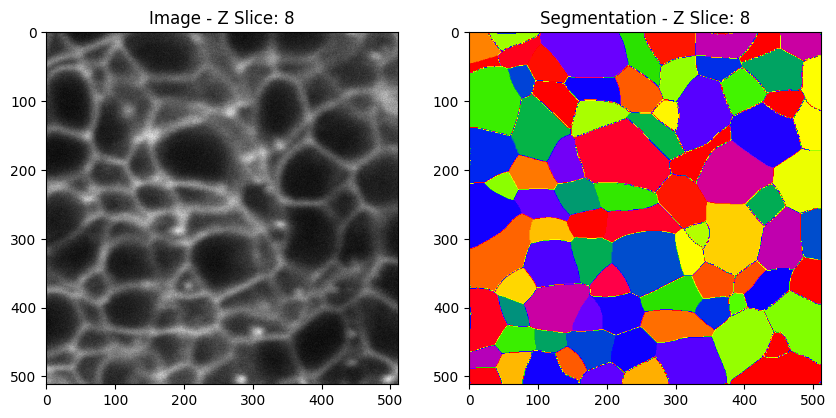

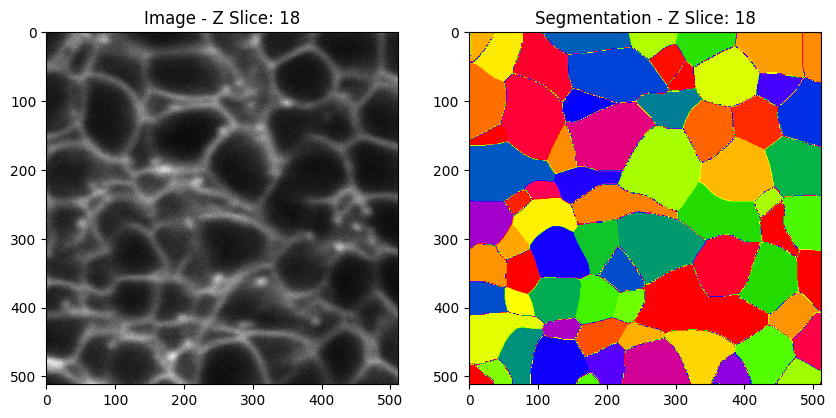

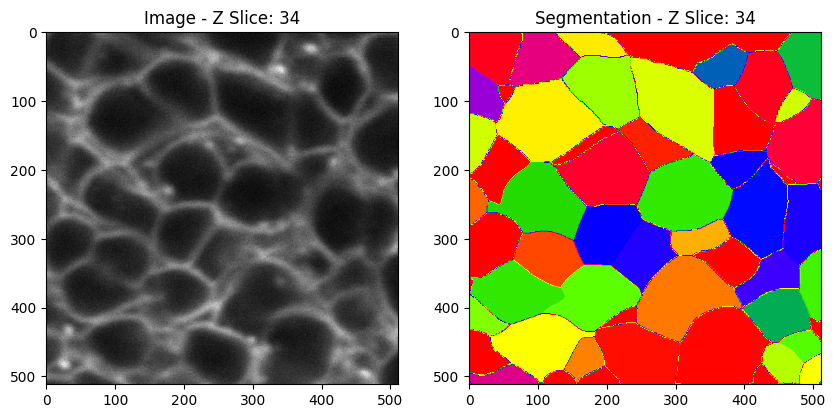

In [ ]:
import matplotlib

def visualize_3d_sections(image, masks, segmented=True, num_sections=3):
    """
    Visualizes different random sections of the 3D image and its segmentation.

    Args:
        image: A 3D numpy array representing the image.
        masks: A 3D numpy array representing the cell masks.
        num_sections: The number of random sections to visualize.
    """

    z_dim = image.shape[0]

    # Generate 'num_sections' random numbers
    random_sections = np.random.randint(0, z_dim, num_sections)

    # Sort the random numbers in ascending order
    random_sections = np.sort(random_sections)

    # Create a colormap for all the sections
    cmap = matplotlib.colormaps.get_cmap('prism')

    for id in range(num_sections):
        z_slice = random_sections[id]
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image[z_slice], cmap='gray')
        plt.title(f"Image - Z Slice: {z_slice}")

        plt.subplot(1, 2, 2)
        if segmented:
          plt.imshow(masks[z_slice], cmap)
          plt.title(f"Segmentation - Z Slice: {z_slice}")
        else:
          plt.imshow(masks[z_slice], cmap='gray')
          plt.title(f"Image - Z Slice: {z_slice}")
        plt.show()

# Get images and masks
files = io.get_image_files(input_dir, '_cp_masks')
images = [io.imread(f) for f in files]
masks = [io.imread(f.replace('.tif', '_cp_masks.tif')) for f in files]

visualize_3d_sections(images[3], masks[3])

#### (Slow) Visualize the cells in 3D

We recommend to use either Napari or Cellpose GUI to visualize 3D segmented cells.

In [ ]:
import numpy as np
import plotly.graph_objects as go
import matplotlib

def visualize_segmented_cells_3d(image, masks):
    """
    Visualizes the segmented cells of a 3D image in a 3D plot using Plotly.

    Args:
        image: A 3D numpy array representing the image.
        masks: A 3D numpy array representing the cell masks.
    """

    # Create a colormap for all the sections
    cmap = matplotlib.colormaps.get_cmap('prism')

    # Create a Plotly figure
    fig = go.Figure()

    # Iterate through each cell mask
    for cell_id in range(1, masks.max() + 1):
        cell_mask = (masks == cell_id)

        # Do not visualize cells smaller than 100 voxels
        if cell_mask.sum() < 100:
            continue

        # Find the coordinates of the cell voxels
        x, y, z = np.where(cell_mask)

        # Plot the cell voxels as a scatter plot
        color = cmap(cell_id / np.max(image))
        rgba_color = f'rgba({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)}, {color[3]})'
        fig.add_trace(go.Scatter3d(
            x=x, y=y, z=z,
            mode='markers',
            marker=dict(size=1, color=rgba_color, opacity=0.5),
            name=f'Cell {cell_id}'
        ))

    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        title='3D Visualization of Segmented Cells'
    )

    fig.show()

visualize_segmented_cells_3d(images[0], masks[0])

## Segmentation evaluation metrics: biology-based
Common metrics used to evaluate the quality of a segmentation are: IoU (Intersection over Union), Dice coefficient, ... However, these metrics are not always suitable for biological images. We have developed a new metric that is more biologically relevant. It also helped us to improve the segmentation results from our manual annotations.




In [19]:
def count_good_cells(mask_img, min_percentage):
  """
  Count the number of cells that are present in a 'min_percentage' of slices.
  @mask_img: 3D mask image
  @min_percentage: minimum percentage of slices that a cell must be present in to be considered a good cell
  return: number of good cells and number of bad cells
  """
  z_planes = mask_img.shape[0]

  # Minimum of number of slices for a cell to be correct
  target_n_planes = (min_percentage / 100 ) * z_planes
  #print(f'Minimum number of z-planes is: {target_n_planes}')

  # Count the number of good cells
  unique_ids = np.unique(mask_img)
  count_good = 0
  count_bad = 0

  # Loop
  for cell_id in unique_ids:
    if cell_id == 0:
      continue

    # Get the voxels of the current cell
    binary_img_pos = np.where(mask_img == cell_id)

    # Get only the unique Z position of the voxels
    unique_z_position = np.unique(binary_img_pos[0])

    # Count the number of slices that the cell is present in
    if len(unique_z_position) > target_n_planes:
        count_good = count_good + 1
    else:
        count_bad = count_bad + 1

  return count_good, count_bad


# Gets image files in directory
files = io.get_image_files(input_dir, '_cp_masks')
masks = [io.imread(f) for f in files]

for mask in masks:
  good_cells, bad_cells = count_good_cells(mask, 95)
  print(f'Number of good cells: {good_cells} and bad cells: {bad_cells}')



100%|██████████| 60/60 [00:00<00:00, 3947.83it/s]


Number of good cells: 85 and bad cells: 95
Number of good cells: 53 and bad cells: 57
Number of good cells: 91 and bad cells: 164
Number of good cells: 53 and bad cells: 33


## Ground truth

We have segmented our data.

In [ ]:
labelled_data = "labelled_data/segmented"

# Gets image files in directory
files = io.get_image_files(labelled_data, '.tif')
masks = [io.imread(f) for f in files]

for mask in masks:
  good_cells, bad_cells = count_good_cells(mask, 95)
  print(f'Number of good cells: {good_cells} and bad cells: {bad_cells}')

100%|██████████| 60/60 [00:00<00:00, 1037.72it/s]


Number of good cells: 61 and bad cells: 73
Number of good cells: 65 and bad cells: 51
Number of good cells: 49 and bad cells: 37
Number of good cells: 72 and bad cells: 49


# 2. Improving raw images for segmentation: Denoising
A very common approach to improve classical segmentation algorithms is to denoise the images. This is done by applying a filter to the images that removes the noise while preserving the structures of interest.
We have tried different denoising algorithms, but none of them improved the segmentation results.

## Deconvolution

In [ ]:
# model name and path

# model name and path
#@markdown ###Name of the pretrained model:
from cellpose import models
restore_type = "oneclick_cyto3" #@param ["denoise_cyto3", "deblur_cyto3", "upsample_cyto3", "oneclick_cyto3", "denoise_cyto2", "deblur_cyto2", "upsample_cyto2", "oneclick_cyto2", "denoise_nuclei", "deblur_nuclei", "upsample_nuclei", "oneclick_nuclei"]

#@markdown ###Path to images:

input_dir = "labelled_data/denoised_raw" #@param {type:"string"}

#@markdown ###Channel Parameters:

Channel_to_use_for_segmentation = "Grayscale" #@param ["Grayscale", "Blue", "Green", "Red"]

# Here we match the channel to number
if Channel_to_use_for_segmentation == "Grayscale":
  chan = 0
elif Channel_to_use_for_segmentation == "Blue":
  chan = 3
elif Channel_to_use_for_segmentation == "Green":
  chan = 2
elif Channel_to_use_for_segmentation == "Red":
  chan = 1

#@markdown ### Segmentation parameters:

#@markdown Diameter of cells (set to zero to use diameter from training set):
diameter =  60#@param {type:"number"}
#@markdown Threshold on cellprob output to seed cell masks (set lower to include more pixels or higher to include fewer, e.g. in range from (-6, 6)):
cellprob_threshold=0 #@param {type:"slider", min:-6, max:6, step:1}
#@markdown Stitch 2D masks into a 3D volume using a stitch_threshold on IOU:
stitch_threshold=0.05 #@param {type:"slider", min:0, max:1, step:0.01}
#@markdown Smooth flows with gaussian filter of this stddev
dP_smooth=0.0 #@param {type:"slider", min:0, max:1, step:0.01}
#@markdown Volumetric stacks do not always have the same sampling in XY as they do in Z
anisotropy=1.0 #@param {type:"slider", min:0, max:2, step:0.01}

In [ ]:
# Copy folder to 'initial_segmentation'
run_str = f'python -m cellpose --save_tif --Zstack --use_gpu --verbose --dir {input_dir} --restore_type {restore_type} --diameter {diameter} --stitch_threshold {stitch_threshold} --dP_smooth {dP_smooth} --anisotropy {anisotropy}'
print(run_str)
!$run_str

python -m cellpose --save_tif --Zstack --use_gpu --verbose --dir labelled_data/denoised_raw --restore_type oneclick_cyto3 --diameter 60 --stitch_threshold 0.05 --dP_smooth 0.0 --anisotropy 1.0
2024-11-11 15:35:18,239 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
2024-11-11 15:35:18,239 [INFO] 
cellpose version: 	3.1.0 
platform:       	linux 
python version: 	3.10.12 
torch version:  	2.5.0+cu121
2024-11-11 15:35:18,454 [INFO] ** TORCH CUDA version installed and working. **
2024-11-11 15:35:18,454 [INFO] >>>> using GPU (CUDA)
2024-11-11 15:35:18,458 [INFO] >>>> running cellpose on 4 images using chan_to_seg GRAY and chan (opt) NONE
2024-11-11 15:35:18,458 [INFO] >> denoise_cyto3 << model set to be used
/usr/local/lib/python3.10/dist-packages/cellpose/resnet_torch.py:271: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will exec

In [ ]:
# Gets image files in directory
files = io.get_image_files(input_dir, '_cp_masks')
masks = [io.imread(f) for f in files]

for mask in masks:
  good_cells, bad_cells = count_good_cells(mask, 95)
  print(f'Number of good cells: {good_cells} and bad cells: {bad_cells}')

100%|██████████| 60/60 [00:00<00:00, 2995.54it/s]


Number of good cells: 85 and bad cells: 95
Number of good cells: 53 and bad cells: 57
Number of good cells: 91 and bad cells: 164
Number of good cells: 53 and bad cells: 33


We can also do it at the same time and we seem to obtain better results, which is not possible on the GUI

2024-11-05 12:08:43,755 [INFO] >> denoise_cyto3 << model set to be used
2024-11-05 12:08:43,766 [INFO] ** TORCH CUDA version installed and working. **
2024-11-05 12:08:43,767 [INFO] >>>> using GPU (CUDA)
2024-11-05 12:08:43,910 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
loading model for chan2: denoise_nuclei


/home/pablo/mambaforge/envs/colab_cellpose/lib/python3.10/site-packages/cellpose/resnet_torch.py:271: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



2024-11-05 12:08:44,041 [INFO] >> cyto3 << model set to be used
2024-11-05 12:08:44,042 [INFO] ** TORCH CUDA version installed and working. **
2024-11-05 12:08:44,043 [INFO] >>>> using GPU (CUDA)
2024-11-05 12:08:44,092 [INFO] >>>> loading model /home/pablo/.cellpose/models/cyto3
2024-11-05 12:08:44,154 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2024-11-05 12:08:44,186 [INFO] reading tiff with 105 planes


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 3755.96it/s]

2024-11-05 12:08:44,236 [INFO] reading tiff with 36 planes



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 3720.74it/s]

2024-11-05 12:08:44,276 [INFO] reading tiff with 38 planes



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 3538.87it/s]

2024-11-05 12:08:44,302 [INFO] reading tiff with 60 planes



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 3212.55it/s]

2024-11-05 12:08:44,326 [INFO] 0%|          | 0/4 [00:00<?, ?it/s]
2024-11-05 12:08:44,327 [WARNING] z_axis not specified, assuming it is dim 0
2024-11-05 12:08:44,328 [WARNING] if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'
2024-11-05 12:08:44,329 [INFO] multi-stack tiff read in as having 105 planes 1 channels


2024-11-05 12:08:44,604 [INFO] 
2024-11-05 12:08:44,605 [INFO] 0%|          | 0/53 [00:00<?, ?it/s]
2024-11-05 12:08:44,606 [INFO] 
2024-11-05 12:08:47,574 [INFO] 100%|##########| 53/53 [00:02<00:00, 17.86it/s]
2024-11-05 12:08:47,602 [INFO] imgs denoised in 3.12s
2024-11-05 12:08:47,629 [WARNING] z_axis not specified, assuming it is dim 0
2024-11-05 12:08:47,630 [WARNING] if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'
2024-11-05 12:08:47,631 [INFO] multi-stack tiff read in as having 36 planes 1 channels
2024-11-05 12:08:47,870 [INFO] 
2024-11-05 12:08:47,871 [INFO] 0%|          | 0/18 [00:00<?, ?it/s]
2024-11-05 12:08:47,872 [INFO] 
2024-11-05 12:08:48,854 [INFO] 100%|##########| 18/18 [00:00<00:00, 18.33it/s]
2024-11-05 12:08:48,865 [INFO] imgs denoised in 1.18s
2024-11-05 12:08:48,881 [WARNING] z_axis not specified, assuming it is dim 0
2024-11-05 12:08:48,882 [WARNING] if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'
2024-11-0

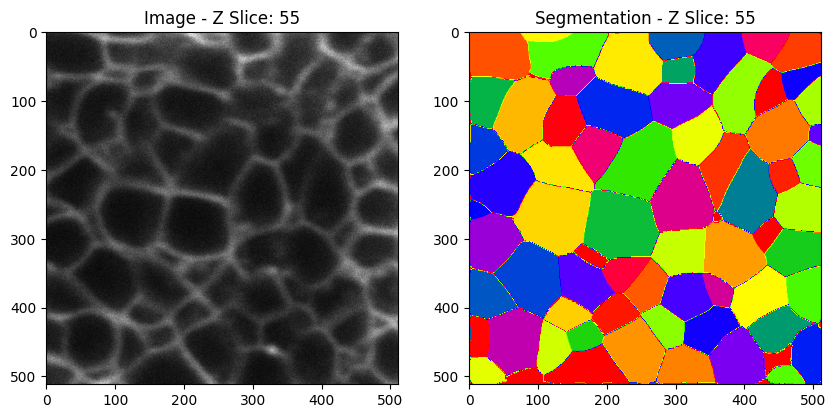

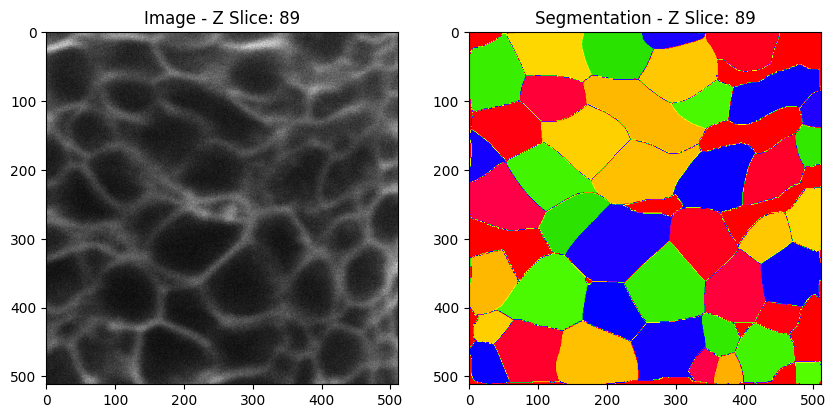

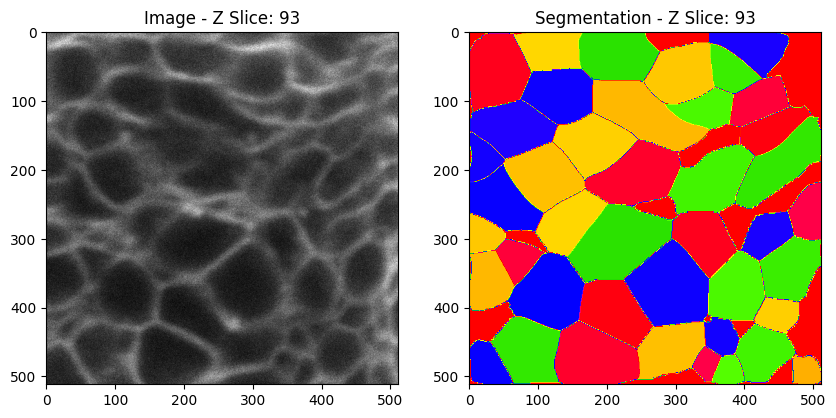

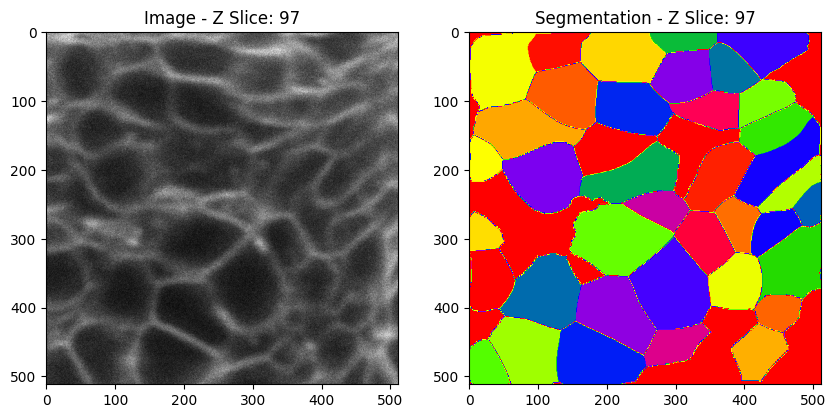

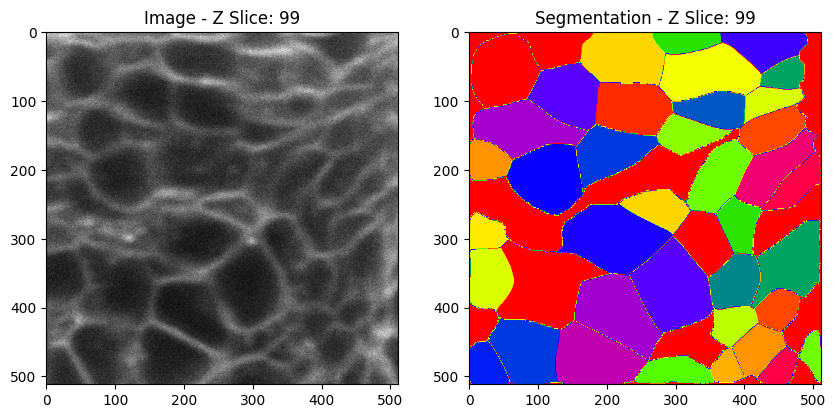

In [ ]:
from cellpose import denoise

# Denoise model
model = denoise.CellposeDenoiseModel(gpu=True, model_type="cyto3",
             restore_type="denoise_cyto3", chan2_restore=True)

# Gets image files in directory (ignoring image files ending in _masks)
files = io.get_image_files(input_dir, '_masks')
images = [io.imread(f) for f in files]

# Compute improved masks
masks, flows, styles, imgs_dn = model.eval(images, channels=[0,0], diameter=diameter)
visualize_3d_sections(images[0], masks[0])

# 3. Refining the segmentation: Cellpose fine-tuning
Cellpose fine-tuning is a feature that allows you to improve the segmentation results by training a new model on your own data.

### From 3D images to 2D images

In [6]:
# Code developed by Alvaro Miranda de Larra and Pablo Vicente-Munuera
import os
import tifffile as tiff

def iterative_image_splicer(input_dir, output_dir, segmented_input=False):

  # Create the output directory if it doesn't exist
  os.makedirs(output_dir, exist_ok=True)

  # Get a list of all .tif files in the input directory
  tif_files = [f for f in os.listdir(input_dir) if f.endswith('.tif')]

  # Iterate over each 3D image
  for tif_file in tif_files:
    if not tif_file.startswith('.'):
      # Load the multi-directory TIFF image
      with tiff.TiffFile(os.path.join(input_dir, tif_file)) as tif:
          image = tif.asarray()

      # Get the shape of the 3D image
      z, y, x = image.shape
      print(image.shape)
      # Generate 2D images along XY, XZ, and YZ coordinates

      for z_coord in range(z):
          xy_image = image[z_coord, :, :]  # XY plane at the current Z coordinate

          # Save the 2D images with appropriate names
          base_name = os.path.splitext(tif_file)[0]
          # Remove '_segmented' from base_name
          base_name = base_name.replace('_segmented', '')
          if segmented_input:
            tiff.imwrite(os.path.join(output_dir, f'{base_name}_XY_Z{z_coord}_masks.tif'), xy_image)
          else:
            tiff.imwrite(os.path.join(output_dir, f'{base_name}_XY_Z{z_coord}.tif'), xy_image)

      for xy_coord in range(x):
          xz_image = image[:, :, xy_coord]  # XZ plane at the current Y coordinate
          yz_image = image[:, xy_coord, :]  # YZ plane at the current X coordinate

          if segmented_input:
            tiff.imwrite(os.path.join(output_dir, f'{base_name}_XZ_Y{xy_coord}_masks.tif'), xz_image)
            tiff.imwrite(os.path.join(output_dir, f'{base_name}_YZ_X{xy_coord}_masks.tif'), yz_image)
          else:
            tiff.imwrite(os.path.join(output_dir, f'{base_name}_XZ_Y{xy_coord}.tif'), xz_image)
            tiff.imwrite(os.path.join(output_dir, f'{base_name}_YZ_X{xy_coord}.tif'), yz_image)

!rm -rf labelled_data_2D/
iterative_image_splicer('labelled_data/raw/', 'labelled_data_2D')
iterative_image_splicer('labelled_data/segmented/', 'labelled_data_2D', segmented_input=True)

(38, 512, 512)
(36, 512, 512)
(60, 512, 512)
(105, 512, 512)
(60, 512, 512)
(105, 512, 512)
(38, 512, 512)
(36, 512, 512)


what the training images look like + their labels

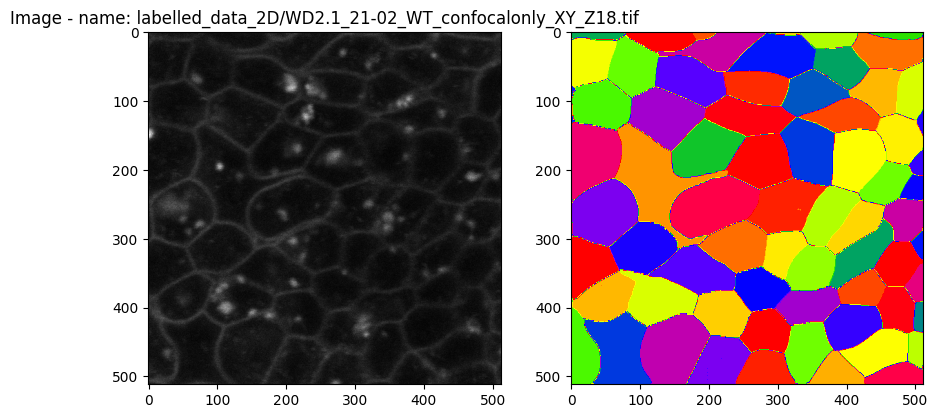

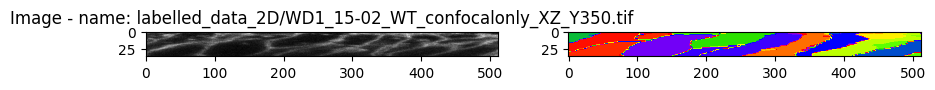

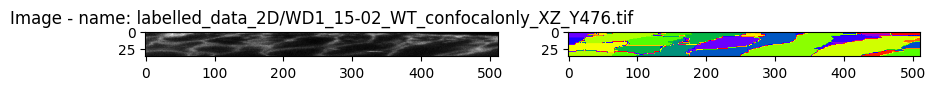

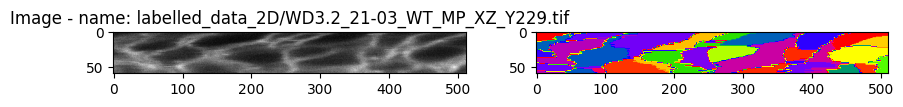

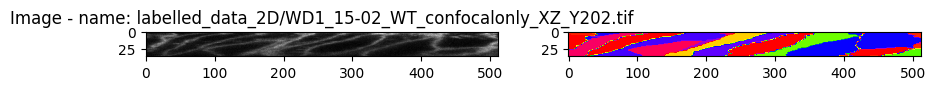

In [7]:
from natsort import natsorted
from glob import glob

train_files = natsorted([f for f in glob('labelled_data_2D/*.tif')
                        if '_masks' not in f])
train_seg = natsorted(glob('labelled_data_2D/*_masks.tif'))

num_images_to_show = 5

# Generate 'num_sections' random numbers
random_sections = np.random.randint(0, len(train_files), num_images_to_show)

# Visualize a few training and segmentation images
for k,f in enumerate(random_sections):
    img = io.imread(train_files[f])
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Image - name: {train_files[f]}")

    # Get the corresponding segmentation image
    seg = io.imread(train_seg[f])
    plt.subplot(1, 2, 2)
    plt.imshow(seg, cmap='prism')
    plt.show()


### Split into training and set test


In [8]:
!rm -rf test/
!rm -rf train/

# Divide sets into training and set test
from sklearn.model_selection import train_test_split

train_files = natsorted([f for f in glob('labelled_data_2D/*.tif')
                        if '_masks.tif' not in f])
train_files, test_files = train_test_split(train_files, test_size=0.2, random_state=42)

# Save files from train into 'train'
os.makedirs('train', exist_ok=True)
for f in train_files:
    shutil.copy(f, 'train')
    # Get the '_mask' from the file f
    shutil.copy(f.replace('.tif', '_masks.tif'), 'train')

# Save files from test into 'test'
os.makedirs('test', exist_ok=True)
for f in test_files:
    shutil.copy(f, 'test')
    # Get the '_mask' from the file f
    shutil.copy(f.replace('.tif', '_masks.tif'), 'test')

### Train model on manual annotations

Skip this step if you already have a pretrained model.

Fill out the form below with the paths to your data and the parameters to start training.

### Training parameters

<font size = 4> **Paths for training, predictions and results**


<font size = 4>**`train_dir:`, `test_dir`:** These are the paths to your folders train_dir (with images and masks of training images) and test_dir (with images and masks of test images). You can leave the test_dir blank, but it's recommended to have some test images to check the model's performance. To find the paths of the folders containing the respective datasets, go to your Files on the left of the notebook, navigate to the folder containing your files and copy the path by right-clicking on the folder, **Copy path** and pasting it into the right box below.

<font size = 4>**`initial_model`:** Choose a model from the cellpose [model zoo](https://cellpose.readthedocs.io/en/latest/models.html#model-zoo) to start from.

<font size = 4>**`model_name`**: Enter the path where your model will be saved once trained (for instance your result folder).

<font size = 4>**Training parameters**

<font size = 4>**`number_of_epochs`:** Input how many epochs (rounds) the network will be trained. At least 100 epochs are recommended, but sometimes 250 epochs are necessary, particularly from scratch. **Default value: 100**



In [14]:
#@markdown ###Path to images and masks:

train_dir = "train" #@param {type:"string"}
test_dir = "test" #@param {type:"string"}
#Define where the patch file will be saved
base = "/content"

# model name and path
#@markdown ###Name of the pretrained model to start from and new model name:
from cellpose import models
initial_model = "cyto3" #@param ["cyto", "cyto3","nuclei","tissuenet_cp3", "livecell_cp3", "yeast_PhC_cp3", "yeast_BF_cp3", "bact_phase_cp3", "bact_fluor_cp3", "deepbacs_cp3", "scratch"]
model_name = "CP_improved" #@param {type:"string"}

# other parameters for training.
#@markdown ###Training Parameters:
#@markdown Number of epochs:
n_epochs =  10#@param {type:"number"}

Channel_to_use_for_training = "Grayscale" #@param ["Grayscale", "Blue", "Green", "Red"]

# @markdown ###If you have a secondary channel that can be used for training, for instance nuclei, choose it here:

Second_training_channel= "None" #@param ["None", "Blue", "Green", "Red"]


#@markdown ###Advanced Parameters

Use_Default_Advanced_Parameters = True #@param {type:"boolean"}
#@markdown ###If not, please input:
learning_rate = 0.1 #@param {type:"number"}
weight_decay = 0.0001 #@param {type:"number"}

if (Use_Default_Advanced_Parameters):
  print("Default advanced parameters enabled")
  learning_rate = 0.1
  weight_decay = 0.0001

#here we check that no model with the same name already exist, if so delete
model_path = train_dir + 'models/'
if os.path.exists(model_path+'/'+model_name):
  print("!! WARNING: "+model_name+" already exists and will be deleted in the following cell !!")

if len(test_dir) == 0:
  test_dir = None

# Here we match the channel to number
if Channel_to_use_for_training == "Grayscale":
  chan = 0
elif Channel_to_use_for_training == "Blue":
  chan = 3
elif Channel_to_use_for_training == "Green":
  chan = 2
elif Channel_to_use_for_training == "Red":
  chan = 1


if Second_training_channel == "Blue":
  chan2 = 3
elif Second_training_channel == "Green":
  chan2 = 2
elif Second_training_channel == "Red":
  chan2 = 1
elif Second_training_channel == "None":
  chan2 = 0

if initial_model=='scratch':
  initial_model = 'None'

Default advanced parameters enabled


### Train new model

Using settings from form above, train model in notebook.

In [15]:
run_str = f'python -m cellpose --use_gpu --verbose --train --dir {train_dir} --pretrained_model {initial_model} --chan {chan} --n_epochs {n_epochs} --learning_rate {learning_rate} --weight_decay {weight_decay} --model_name_out {model_name}'
if test_dir is not None:
    run_str += f' --test_dir {test_dir}'
print(run_str)
!$run_str

python -m cellpose --use_gpu --verbose --train --dir train --pretrained_model cyto3 --chan 0 --n_epochs 10 --learning_rate 0.1 --weight_decay 0.0001 --model_name_out CP_improved --test_dir test
2024-11-12 11:50:21,419 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
2024-11-12 11:50:21,419 [INFO] 
cellpose version: 	3.1.0 
platform:       	linux 
python version: 	3.10.12 
torch version:  	2.5.0+cu121
2024-11-12 11:50:21,533 [INFO] ** TORCH CUDA version installed and working. **
2024-11-12 11:50:21,533 [INFO] >>>> using GPU (CUDA)
2024-11-12 11:50:21,949 [INFO] not all flows are present, running flow generation for all images
2024-11-12 11:50:26,199 [INFO] 3468 / 3468 images in train folder have labels
2024-11-12 11:50:26,290 [INFO] not all flows are present, running flow generation for all images
2024-11-12 11:50:27,159 [INFO] 867 / 867 images in test folder have labels
2024-11-12 11:50:27,159 [INFO] >>>> during training rescaling images to fixed diameter of 30.0 pixels
2024-11-12 

## Evaluate on test data (optional)

In [21]:
# model name and path

# model name and path
#@markdown ###Name of the pretrained model:
from cellpose import models
initial_model = "CP_improved" #@param {type:"string"}

#@markdown ###Path to images:

input_dir = "labelled_data/improved_model" #@param {type:"string"}

#@markdown ###Channel Parameters:

Channel_to_use_for_segmentation = "Grayscale" #@param ["Grayscale", "Blue", "Green", "Red"]

# Here we match the channel to number
if Channel_to_use_for_segmentation == "Grayscale":
  chan = 0
elif Channel_to_use_for_segmentation == "Blue":
  chan = 3
elif Channel_to_use_for_segmentation == "Green":
  chan = 2
elif Channel_to_use_for_segmentation == "Red":
  chan = 1

#@markdown ### Segmentation parameters:

#@markdown Diameter of cells (set to zero to use diameter from training set):
diameter =  60#@param {type:"number"}
#@markdown Threshold on cellprob output to seed cell masks (set lower to include more pixels or higher to include fewer, e.g. in range from (-6, 6)):
cellprob_threshold=0 #@param {type:"slider", min:-6, max:6, step:1}
#@markdown Stitch 2D masks into a 3D volume using a stitch_threshold on IOU:
stitch_threshold=0.05 #@param {type:"slider", min:0, max:1, step:0.01}
#@markdown Smooth flows with gaussian filter of this stddev
dP_smooth=0.0 #@param {type:"slider", min:0, max:1, step:0.01}
#@markdown Volumetric stacks do not always have the same sampling in XY as they do in Z
anisotropy=1.0 #@param {type:"slider", min:0, max:2, step:0.01}
#@markdown Exclude cells at the edges to be segmented
exclude_edges=True #@param {type:"boolean"}

In [24]:
run_str = f'python -m cellpose --use_gpu --save_tif --Zstack --verbose --dir {input_dir} --pretrained_model train/models/{initial_model} --chan {chan} --diameter {diameter} --stitch_threshold {stitch_threshold} --dP_smooth {dP_smooth} --anisotropy {anisotropy}'
if exclude_edges:
    run_str += f' --exclude_on_edges'
print(run_str)
!$run_str

python -m cellpose --use_gpu --save_tif --Zstack --verbose --dir labelled_data/improved_model --pretrained_model train/models/CP_improved --chan 0 --diameter 60 --stitch_threshold 0.05 --dP_smooth 0.0 --anisotropy 1.0 --exclude_on_edges
2024-11-12 13:24:04,160 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
2024-11-12 13:24:04,160 [INFO] 
cellpose version: 	3.1.0 
platform:       	linux 
python version: 	3.10.12 
torch version:  	2.5.0+cu121
2024-11-12 13:24:04,269 [INFO] ** TORCH CUDA version installed and working. **
2024-11-12 13:24:04,269 [INFO] >>>> using GPU (CUDA)
2024-11-12 13:24:04,272 [INFO] >>>> running cellpose on 4 images using chan_to_seg GRAY and chan (opt) NONE
2024-11-12 13:24:04,366 [INFO] >>>> loading model train/models/CP_improved
/usr/local/lib/python3.10/dist-packages/cellpose/resnet_torch.py:271: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to 

In [25]:
# Gets image files in directory
files = io.get_image_files(input_dir, '_cp_masks')
masks = [io.imread(f) for f in files]

for mask in masks:
  good_cells, bad_cells = count_good_cells(mask, 95)
  print(f'Number of good cells: {good_cells} and bad cells: {bad_cells}')


100%|██████████| 60/60 [00:00<00:00, 3073.05it/s]


Number of good cells: 85 and bad cells: 95
Number of good cells: 53 and bad cells: 57
Number of good cells: 91 and bad cells: 164
Number of good cells: 53 and bad cells: 33


In [ ]:
# get files (during training, test_data is transformed so we will load it again)
output = io.load_train_test_data(test_dir, mask_filter='')
test_data, test_labels = output[:2]

# run model on test images
masks = model.eval(test_data, channels=[0, 0], diameter=diameter)[0]

# check performance using ground truth labels
ap = metrics.average_precision(test_labels, masks)[0]

print(f'>>> average precision at iou threshold 0.5 = {ap[:,0].mean():.3f}')
print(f'>>> average precision at iou threshold 0.75 = {ap[:,1].mean():.3f}')
print(f'>>> average precision at iou threshold 0.95 = {ap[:,2].mean():.3f}')


2024-11-05 14:38:44,137 [INFO] 867 / 867 images in test folder have labels
2024-11-05 14:39:22,098 [INFO] 23%|##2       | 198/867 [00:30<01:41,  6.58it/s]
2024-11-05 14:39:29,484 [INFO] No cell pixels found.
2024-11-05 14:39:30,196 [INFO] No cell pixels found.
2024-11-05 14:39:30,921 [INFO] No cell pixels found.
2024-11-05 14:39:30,981 [INFO] No cell pixels found.
2024-11-05 14:39:32,023 [INFO] No cell pixels found.
2024-11-05 14:39:32,072 [INFO] No cell pixels found.
2024-11-05 14:39:32,729 [INFO] No cell pixels found.
2024-11-05 14:39:35,427 [INFO] No cell pixels found.
2024-11-05 14:39:35,525 [INFO] No cell pixels found.
2024-11-05 14:39:35,547 [INFO] No cell pixels found.
2024-11-05 14:39:35,563 [INFO] No cell pixels found.
2024-11-05 14:39:37,637 [INFO] 23%|##2       | 198/867 [00:45<01:41,  6.58it/s]
2024-11-05 14:39:50,381 [INFO] No cell pixels found.
2024-11-05 14:39:50,391 [INFO] No cell pixels found.
2024-11-05 14:39:50,401 [INFO] No cell pixels found.
2024-11-05 14:39:51,205

/home/pablo/mambaforge/envs/colab_cellpose/lib/python3.10/site-packages/cellpose/dynamics.py:508: UserWarning:

The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)



IndexError: tuple index out of range

In [ ]:

plt.figure(figsize=(12,8), dpi=150)
for k,im in enumerate(test_data):
    img = im.copy()
    plt.subplot(3,len(train_files), k+1)
    img = np.vstack((img, np.zeros_like(img)[:1]))
    img = img.transpose(1,2,0)
    plt.imshow(img)
    plt.axis('off')
    if k==0:
        plt.title('image')

    plt.subplot(3,len(train_files), len(train_files) + k+1)
    plt.imshow(masks[k])
    plt.axis('off')
    if k==0:
        plt.title('predicted labels')

    plt.subplot(3,len(train_files), 2*len(train_files) + k+1)
    plt.imshow(test_labels[k])
    plt.axis('off')
    if k==0:
        plt.title('true labels')
plt.tight_layout()

# 4.Tracking cells in 3D: custom stitching method
We still had issues with our segmentation results, especially when cells were touching each other. Therefore, we used TrackMate to track cells in 3D and then stitched the cells together. This allowed us to obtain a more accurate segmentation of the cells.